# Analyze ROCIS/DFT data

In [1]:
import sys
sys.path.append('/home/kotobiam/hida_project/')

In [2]:
import pandas as pd 
import numpy as np
import os.path as osp
import math
import copy

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='whitegrid', palette='muted', font_scale=1.5)

from pylab import rc, rcParams
rc('text', usetex=False)
rc('axes', linewidth=2)
rc('font', weight='normal')

params = {'legend.fontsize': 17,
          'figure.figsize': (8, 6),
         'axes.labelsize': 25,
         'axes.titlesize': 25,
         'xtick.labelsize':25,
         'ytick.labelsize':25,
         'figure.dpi' : 200}
rcParams.update(params)
from matplotlib.ticker import FormatStrFormatter

from attribution_gnn1.QM9_SpecData import QM9_SpecData
from utils.cams import cam_gnn, cam_graphnet
from src.models import SpectraGNN, SpectraGAT, SpectraGraphNet

from utils.graph_preprocessing import GraphDataProducer
from utils.ground_truth import GroundTruthGenerator
from utils.ground_truth import OrcaAnlyser, Contributions
from utils.auc_roc import auc, plot_roc_curve

import torch

In [ ]:
device = 'cpu'

# Models 

In [ ]:
spectragnn = SpectraGNN(
    gnn_name='gcn',
    in_channels=[11, 128, 256, 512],
    out_channels=[128, 256, 512, 600],
    num_targets=100,
    num_layers=4,
    heads=None
).to(device)

# loading the saved model 
path_to_model = osp.join('/home/kotobiam/hida_project/trained_models/models_diff_arch/spectragnn_50k_gcn/best_model', 
                         'spectragcn_50k.pt')

if osp.exists(path_to_model):
    spectragnn.load_state_dict(torch.load(path_to_model))
else:
    print('model is not loaded')

In [63]:
spectragat = SpectraGAT(
    node_features_dim=11,
    in_channels=[128, 128, 128, 128],
    out_channels=[128, 128, 128, 400],
    targets=100,
    n_layers=4,
    n_heads=3,
    gat_type = 'gatv2_custom',
    use_residuals=True,
    use_jk=True
).to(device)

# loading the saved model 
path_to_saved_model = ('/home/kotobiam/hida_project/trained_models/'\
                       'models_diff_arch/spectragat_50k_gatv2cus/best_model/spectragatv2_50k.pt')
if osp.exists(path_to_saved_model):
    spectragat.load_state_dict(torch.load(path_to_saved_model))
else:
    print('model is not loaded')

In [95]:
node_model_params = {"feat_in": 39, "feat_hidd": 64, "feat_out": 50}
edge_model_params = {"feat_in": 124, "feat_hidd": 64, "feat_out": 50}
global_model_params = {"feat_in": 120, "feat_hidd": 64, "feat_out": 50}

node_model_params1 = {"feat_in": 200, "feat_hidd": 64, "feat_out": 50}
edge_model_params1 = {"feat_in": 200, "feat_hidd": 64, "feat_out": 50}
global_model_params1 = {"feat_in": 150, "feat_hidd": 64, "feat_out": 50}

node_model_params2 = {"feat_in": 200, "feat_hidd": 64, "feat_out": 50}
edge_model_params2 = {"feat_in": 200, "feat_hidd": 64, "feat_out": 50}
global_model_params2 = {"feat_in": 150, "feat_hidd": 64, "feat_out": 50}

In [96]:
all_params = {"graphnet0": {"node_model_params": node_model_params,
            "edge_model_params": edge_model_params,
            "global_model_params": global_model_params},
             
             "graphnet1": {"node_model_params": node_model_params1,
            "edge_model_params": edge_model_params1,
            "global_model_params": global_model_params1},
             
             "graphnet2": {"node_model_params": node_model_params2,
            "edge_model_params": edge_model_params2,
            "global_model_params": global_model_params2}}

In [97]:
spectragraphnet = SpectraGraphNet(all_params=all_params, n_layers=3, 
                                  lin_in=50, n_targets=100).to(device)

# loading the saved model 
path_to_model = ('/home/kotobiam/hida_project/trained_models/'\
                'models_diff_arch/spectragraphnet_50k/best_model/spectragraphnet_50k.pt')

if osp.exists(path_to_model):
    spectragraphnet.load_state_dict(torch.load(path_to_model))
else:
    print('model is not loaded')

# test data preparation and pick a graph

In [3]:
path_to_data = '/home/kotobiam/data_qm9/qm9_spec_test_0-8eV.pt'
test_data = QM9_SpecData(
            root=path_to_data,
            raw_dir='/home/kotobiam/data_qm9/raw/',
            spectra=[]
        )

In [ ]:
mol_idx = 9088
#1517
#41219
#41219
#51470
graph_picker = GraphDataProducer(
    model=spectragnn,
    gnn_type="gcn",
    test_data=test_data,
    idx_to_pick=mol_idx
)
graph = graph_picker.picked_graph

In [ ]:
graph

In [33]:
y_true = graph.spectrum
x_pred, y_pred = graph_picker.predictions()

In [34]:
atomic_num = graph.z
label_map = {1: 'H', 6: 'C', 7: 'N', 8: 'O', 9: 'F'}
atom_labels = []
for i, z in enumerate(atomic_num):
    atom_labels.append(f"{label_map[z.item()]} {i}")

## CAM data 

In [36]:
cam_gcn = cam_gnn(graph, spectragnn)

In [20]:
cam_gragh = cam_graphnet(graph, spectragraphnet)

In [129]:
cam_gatv2 = cam_gat(x, edge_index,
               spectragat, 
               device=device,  
               best_model_path=('/p/home/jusers/kotobi2/juwels/hida_project/trained_models/'\
                       'models_diff_arch/spectragat_50k_gatv2cus/best_model/spectragatv2_50k.pt'))

In [59]:
cam_gcn

tensor([[0.0000e+00, 1.1414e-04, 3.2112e-03,  ..., 2.4675e+02, 2.9699e+02,
         3.5759e+02],
        [0.0000e+00, 1.1622e-04, 4.1438e-03,  ..., 3.2527e+02, 3.7987e+02,
         4.5213e+02],
        [0.0000e+00, 1.1514e-04, 3.3271e-03,  ..., 3.8022e+02, 3.7262e+02,
         3.8035e+02],
        ...,
        [0.0000e+00, 2.7286e-05, 2.0547e-03,  ..., 2.6817e+02, 2.4155e+02,
         2.0940e+02],
        [0.0000e+00, 2.7286e-05, 2.0547e-03,  ..., 2.6817e+02, 2.4155e+02,
         2.0940e+02],
        [2.0505e-03, 1.3989e-04, 1.9786e-03,  ..., 2.0803e+02, 1.6309e+02,
         1.1906e+02]])

In [37]:
all_cam_data = pd.DataFrame(np.c_[x_pred, y_pred, cam_gcn.T], 
             columns=['energies', 'osc', *atom_labels])

# obtaining the contributions of the atoms 

In [38]:
from utils.ground_truth import OrcaAnlyser, Contributions

In [39]:
path_orca_output = ('/beegfs/desy/user/kotobiam/DFT_calculations/nexafs_dataset_prep/QM9_dataset_nexafs/'\
                    f"nexafs_cals_QM9/structure_{mol_idx}/structure_{mol_idx}.out")
path_orca_spectrum = ('/beegfs/desy/user/kotobiam/DFT_calculations/nexafs_dataset_prep/QM9_dataset_nexafs/'\
                    f"nexafs_cals_QM9/structure_{mol_idx}/structure_{mol_idx}.out.abs.stk")

orca_analyzer = OrcaAnlyser(path_orca_output,
                            path_orca_spectrum)

In [40]:
excitations = orca_analyzer.give_excitations()

In [57]:
contributions = Contributions(excitations, 
                              all_cam_data, 
                              281, atom_labels)

In [58]:
acc, don = contributions.don_acc_contrs()

cam_contr = contributions.cam_contrs()

## read smiles

In [3]:
from rdkit import Chem
from rdkit.Chem import Draw
import pandas as pd
size = (120, 120)

In [4]:
path_to_smile = '/home/kotobiam/data_qm9/qm9.csv'

In [5]:
qm9_smiles = pd.read_csv(path_to_smile, usecols=['smiles'])

In [13]:
mol_idx = 12100
qm9_smiles.loc[mol_idx].values

array(['OC1CC1C1(O)CC1'], dtype=object)

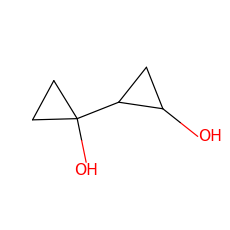

In [14]:
m = Chem.MolFromSmiles(str(qm9_smiles.loc[mol_idx].values[0]))
fig = Draw.MolToMPL(m, size=size)
plt.grid(False)
plt.axis('off')
plt.savefig("./smiles.png", 
                    dpi=300, 
                    bbox_inches='tight')

# Visualisation and peak finder

In [41]:
from utils.visualisation import plot_prediction

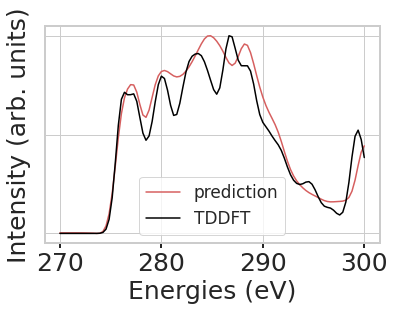

In [42]:
plot_prediction(x_pred, 
                y_pred, 
                y_true, 
                normalise=True, 
                add_peaks=False,
                save=False)

## Visualise TD-DFT data with stk data 

In [27]:
import numpy as np

In [11]:
mol_idx = 55471
path_orca_output = ('/beegfs/desy/user/kotobiam/DFT_calculations/nexafs_dataset_prep/QM9_dataset_nexafs/'\
                    f"nexafs_cals_QM9/structure_{mol_idx}/structure_{mol_idx}.dat")
path_orca_spectrum = ('/beegfs/desy/user/kotobiam/DFT_calculations/nexafs_dataset_prep/QM9_dataset_nexafs/'\
                    f"nexafs_cals_QM9/structure_{mol_idx}/structure_{mol_idx}.out.abs.stk")

In [12]:
df_spec = pd.DataFrame({'x': x_pred, 'y': y_true})
df_stk = pd.DataFrame(np.loadtxt(path_orca_spectrum)[:, :2])

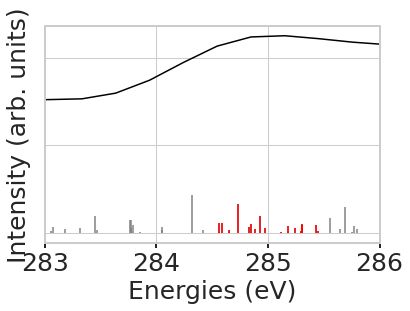

In [49]:
fig, ax = plt.subplots()

ax.plot(df_spec.x, df_spec.y, color='black')
ax.vlines(df_stk[0], 0, df_stk[1], color='gray')#, alpha=0.5)

mask = (df_stk[0] > 284.5) & (df_stk[0] < 285.5)
ax.vlines(df_stk[mask][0], 0, df_stk[mask][1], color='red')
#ax.legend()
ax.set_yticklabels([])
ax.set_xlabel('Energies (eV)')
ax.set_xlim(283, 286)#275, 297) 
ax.set_ylabel('Intensity (arb. units)')
ax.tick_params(axis='x', which='major', direction='out', 
                bottom=True, width=2, length=5)
plt.savefig("./spec_55471_section.png",  dpi=500, bbox_inches='tight')

In [28]:
from rdkit import Chem
import networkx as nx

In [29]:
def plot_graph(graph, symbols, 
               weights, save_fig=False,
               acceptor_orb=False, don_orb=False):
    if acceptor_orb:
        cmap = plt.cm.Blues
    elif don_orb:
        cmap = plt.cm.Reds
    else:
        cmap = plt.cm.Greens
        
    G=nx.Graph()
    
    for i, w in zip(range(graph.x.shape[0]),
                 weights):
        G.add_node(i, weight=w)

    target = graph.edge_index[0].tolist()
    source = graph.edge_index[1].tolist()

    for i, j in zip(target, source):
        G.add_edge(i, j)
        
    
    pos_dict = {}
    for i, xyz in enumerate(graph.pos):
        pos_dict[i] = xyz[:-1].detach().cpu().numpy()
     
    pos_g=nx.spring_layout(G, pos=pos_dict)
    
    nx.draw(G, pos=pos_g, node_color=weights,
            node_size=1000, cmap=cmap, with_labels=False)
    labels=nx.draw_networkx_labels(G, pos=pos_g, labels=symbols, 
                                   font_size=14, font_color='black',
                                  font_weight='bold')
    if save_fig:
        plt.savefig('./CAM_fig.png', dpi=300, bbox_inches='tight')
    
    return G

In [30]:
#atoms = list(atom_cam_weights.index)
labels = dict(zip(
    np.arange(len(atom_labels)),
    atom_labels
))

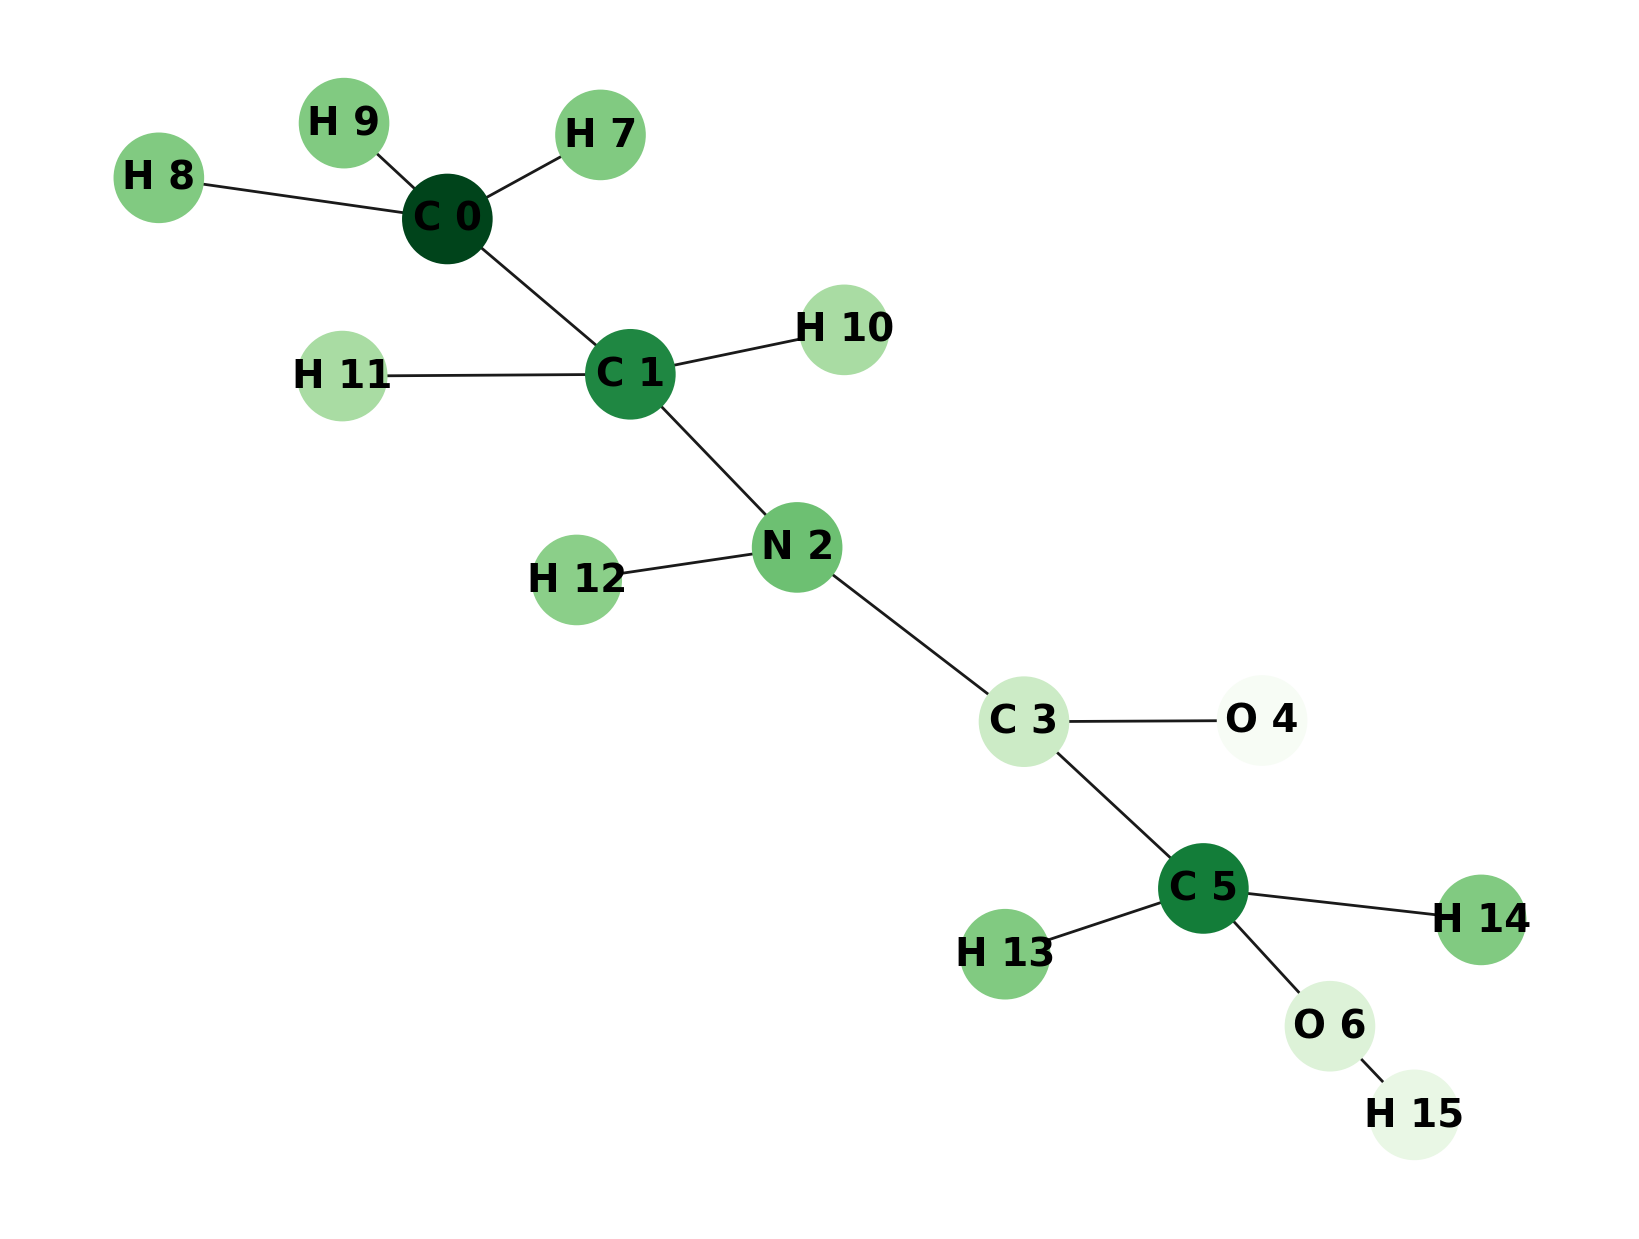

In [59]:
nx_g_cam = plot_graph(graph, labels, 
           cam_contr['weights'], 
           save_fig=False,
           acceptor_orb=False)

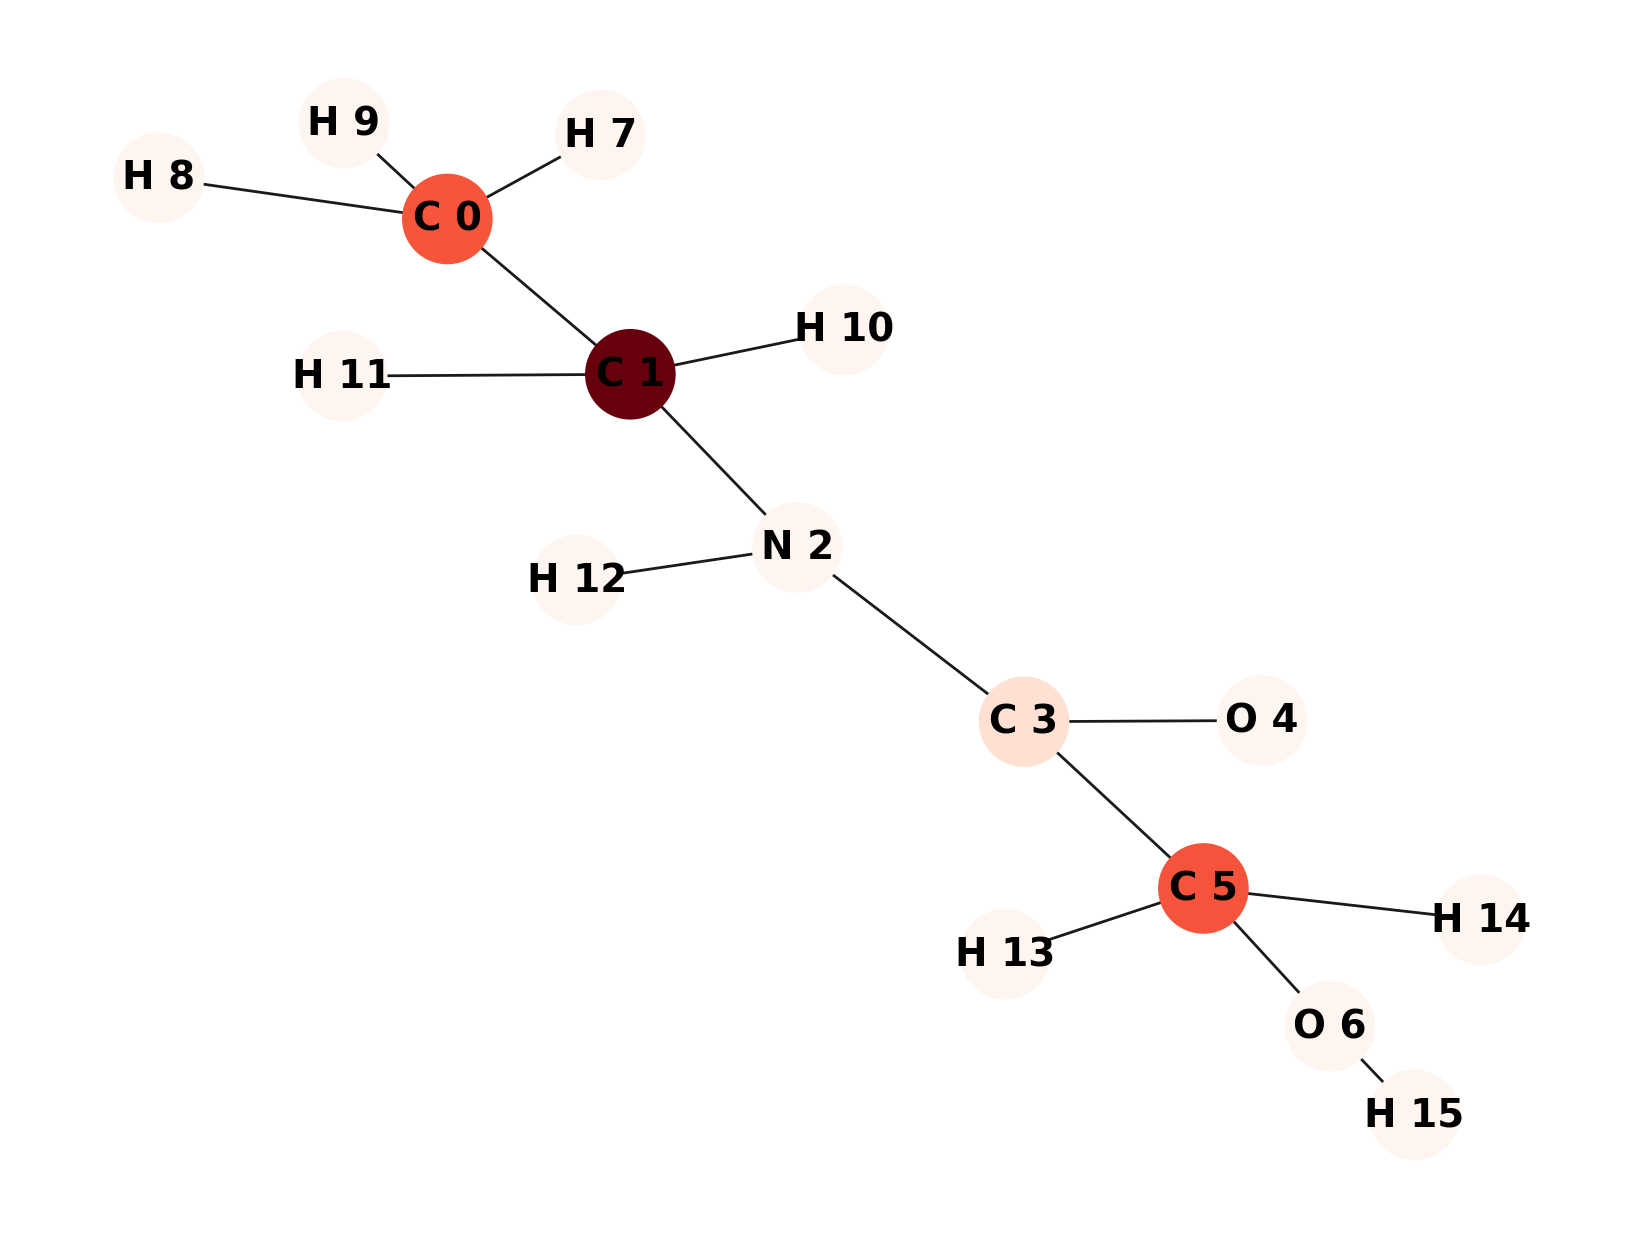

In [60]:
nx_g_don = plot_graph(graph, labels, 
           don['weights'], 
           save_fig=False,
           don_orb=True)

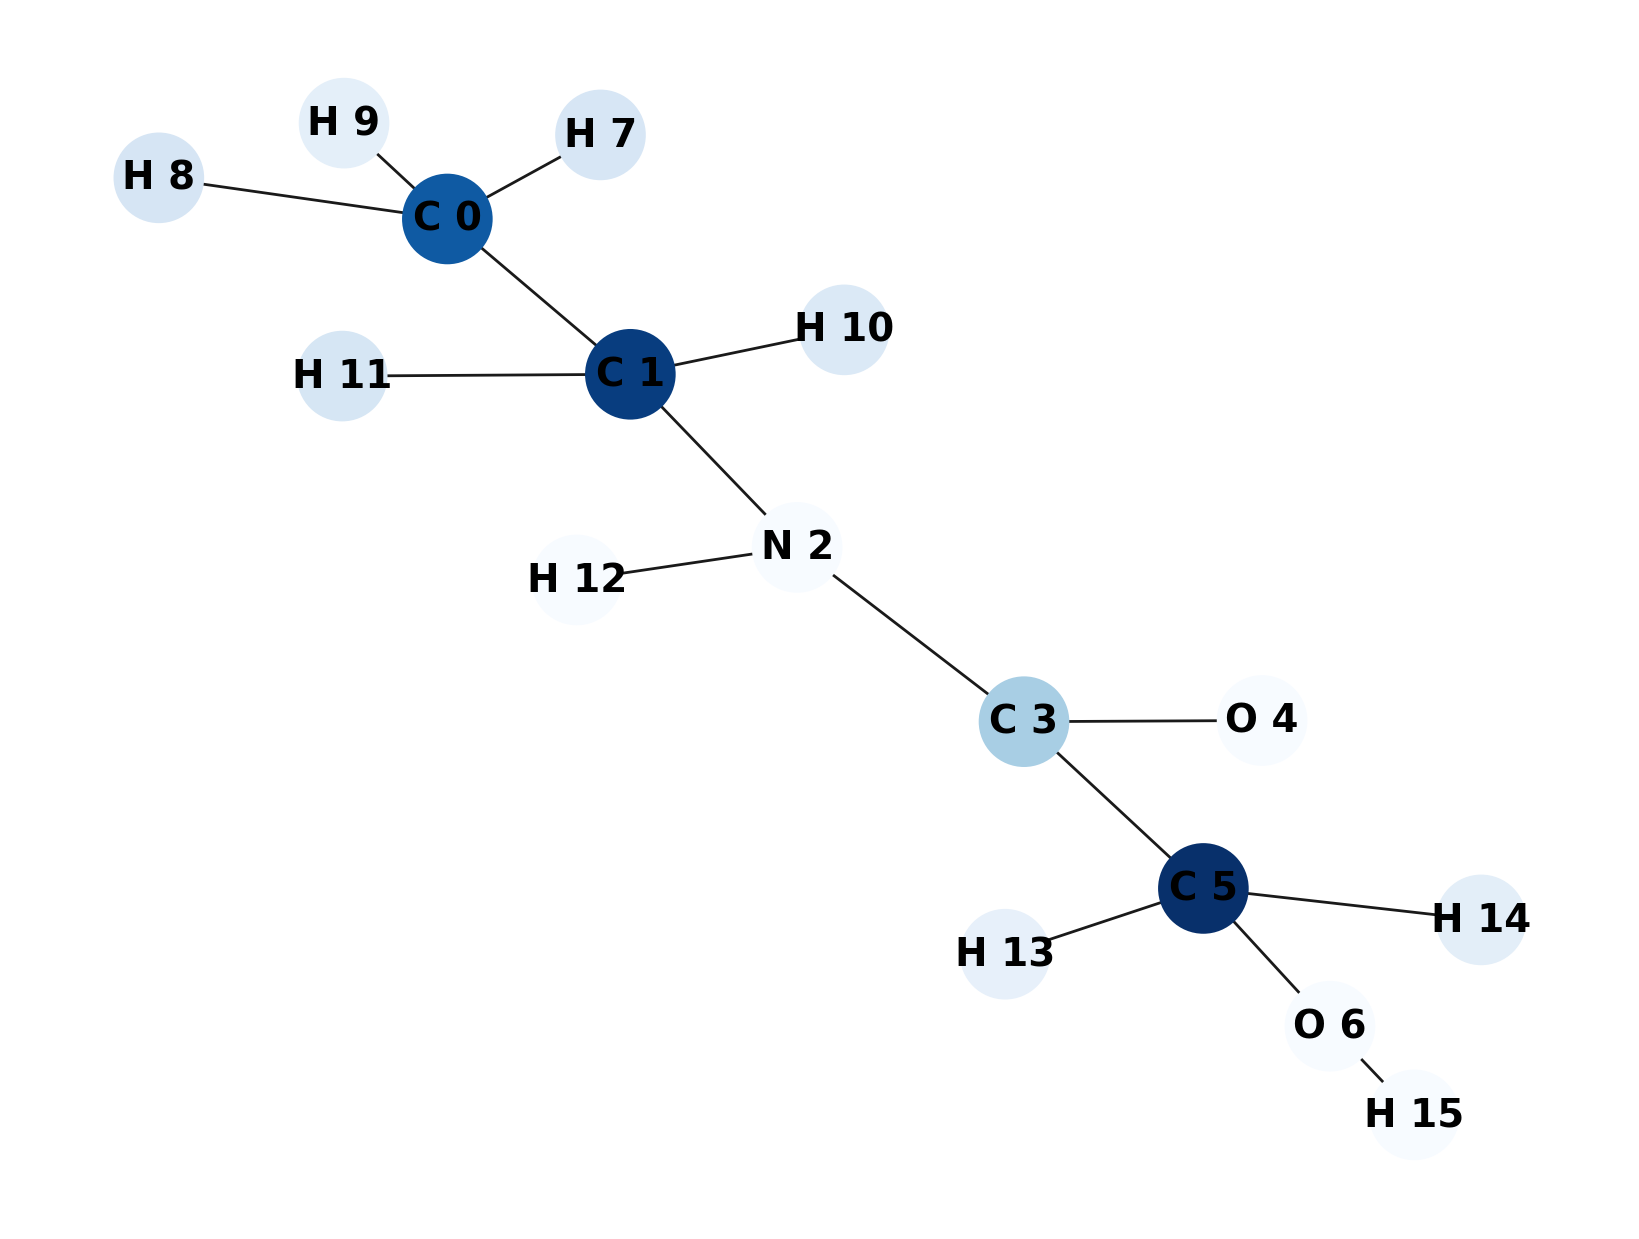

In [61]:
nx_g_acc = plot_graph(graph, labels, 
           acc['weights'], 
           save_fig=False,
           acceptor_orb=True)

In [27]:
df_vis_xai = pd.DataFrame({"smiles": qm9_smiles.loc[mol_idx].values[0],
             "networkx graph CAM": [nx_g_cam],
             "networkx graph donor": [nx_g_don],
             "networkx graph acceptor": [nx_g_acc],
             "graph": [graph]})

In [28]:
df_vis_xai["networkx graph CAM"].values[0].nodes.data()

NodeDataView({0: {'weight': 0.5249176862745981}, 1: {'weight': 0.23546704896848458}, 2: {'weight': 0.8605635364637958}, 3: {'weight': 0.5268657008362376}, 4: {'weight': 0.9347739776122983}, 5: {'weight': 1.0}, 6: {'weight': 0.9908080095796081}, 7: {'weight': 0.4501192399672935}, 8: {'weight': 0.8472326968496415}, 9: {'weight': 0.0}, 10: {'weight': 0.0}, 11: {'weight': 0.01597565526450373}, 12: {'weight': 0.18243455862672575}, 13: {'weight': 0.36587102092393853}, 14: {'weight': 0.36587102092393853}, 15: {'weight': 0.16749208287621287}, 16: {'weight': 0.4995895391048055}})

In [29]:
df_vis_xai.to_pickle(f"./vis_xai_{mol_idx}.pkl")

In [30]:
pd.read_pickle(f"./vis_xai_{mol_idx}.pkl")["graph"][0]

FileNotFoundError: [Errno 2] No such file or directory: './vis_xai_41219.pkl'

# AUC-ROC of spectra 

In [62]:
from utils.auc_roc import auc, plot_roc_curve

In [67]:
scores = np.asarray(cam_contr['weights'])
contributions = np.asarray(don['weights'])

In [68]:
auc_score, fpr, tpr = auc(scores, contributions)

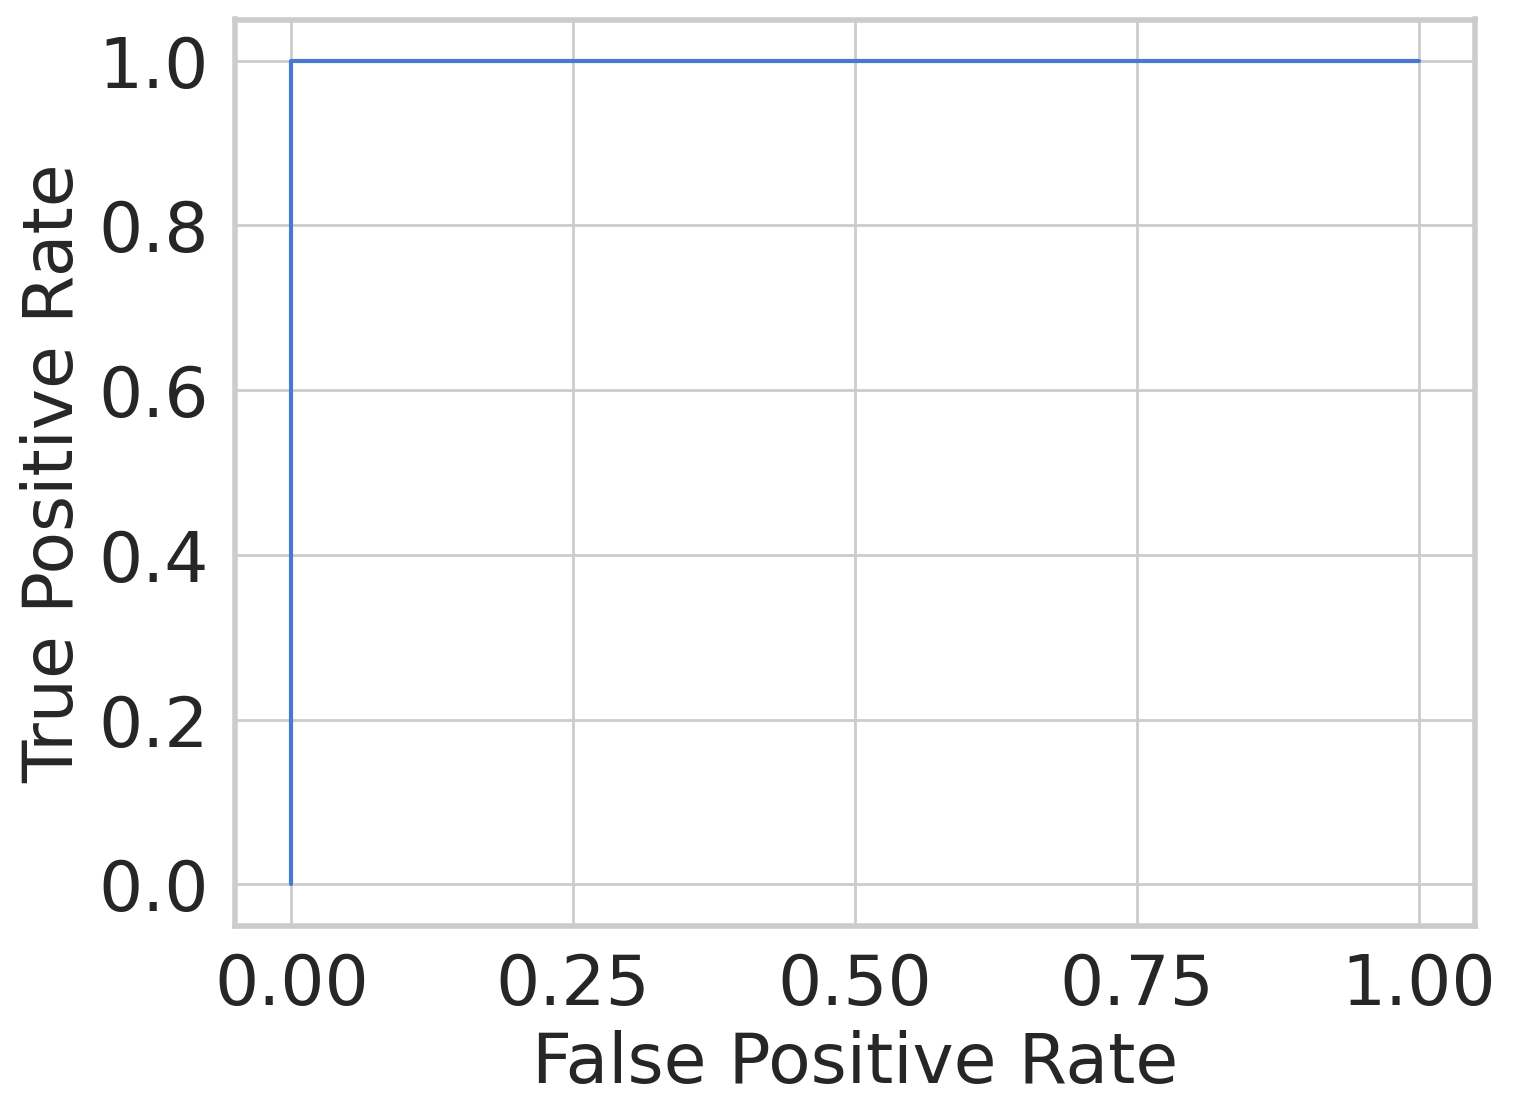

In [69]:
plot_roc_curve(fpr, tpr)

In [70]:
auc_score

1.0

# Calculate batch of AUC-ROC

In [77]:
gt_generator = GroundTruthGenerator(
    model=spectragraphnet,
    gnn_type="graphNet",
    test_data=test_data,
    path_to_orca_data=("/beegfs/desy/user/kotobiam/DFT_calculations/"\
                       "nexafs_dataset_prep/QM9_dataset_nexafs/nexafs_cals_QM9/")
)

In [53]:
#wanted_idx = [7276, 1517, 11197]
def return_idx(test_data, wanted_idx):
    for i, graph in enumerate(test_data):
        if graph.idx == wanted_idx:
            return i

In [ ]:
# a list of dictionaries for all molecules in test dataset which have peak energies as the keys and dict of 
# AUCs for donor and acceptor
gt_qm9_all  = gt_generator[0:6000]

In [60]:
gt_qm9_single  = gt_generator[2]

In [61]:
gt_qm9_single

{276.3636363636364: {'auc_donor': (1.0,
   array([0.        , 0.        , 0.        , 0.28571429, 0.57142857,
          1.        ]),
   array([0. , 0.5, 1. , 1. , 1. , 1. ])),
  'auc_acceptor': (1.0,
   array([0.   , 0.   , 0.375, 0.625, 1.   ]),
   array([0., 1., 1., 1., 1.]))},
 281.8181818181818: {'auc_donor': (1.0,
   array([0.        , 0.        , 0.        , 0.33333333, 0.5       ,
          1.        ]),
   array([0.        , 0.33333333, 1.        , 1.        , 1.        ,
          1.        ])),
  'auc_acceptor': (1.0,
   array([0.        , 0.        , 0.        , 0.33333333, 0.5       ,
          1.        ]),
   array([0.        , 0.33333333, 1.        , 1.        , 1.        ,
          1.        ]))},
 287.8787878787879: {'auc_donor': (1.0,
   array([0.        , 0.        , 0.        , 0.42857143, 0.71428571,
          1.        ]),
   array([0. , 0.5, 1. , 1. , 1. , 1. ])),
  'auc_acceptor': (1.0,
   array([0.        , 0.        , 0.        , 0.42857143, 0.71428571,
    

In [38]:
avg_auc_donor = []
avg_auc_acc = []
for gt in gt_qm9_all:
    avg_auc_donor.append(
        np.mean([gt_mol['auc_donor'][0]\
                 for gt_mol in gt.values()])
    )
    avg_auc_acc.append(
        np.mean([gt_mol['auc_acceptor'][0]\
                 for gt_mol in gt.values()])
    )

NameError: name 'gt_qm9_all' is not defined

In [39]:
pd.DataFrame({"avg_auc_acc": avg_auc_acc, 
              "avg_auc_don": avg_auc_donor}).to_csv("./avg_auc_gatv2cus.csv")

In [ ]:
avg_auc_acc

## ploting the boxplot of all AUC values

In [102]:
gnns = ['gatv2', 'gcn', 'graphNet']
auc_gnns = {}
for gnn in gnns:
    auc_gnns[gnn] = pd.read_csv(f"/home/kotobiam/hida_project/data/avg_auc/old/avg_auc_{gnn}.csv").fillna(0)

In [103]:
df_auc_gnns = pd.DataFrame()

for gnn_type, df_gnn in auc_gnns.items():
    df = pd.DataFrame()
    df_gnn['acc'] = 'Virtual'
    df_gnn['don'] = 'Core'
    df['orbital'] = pd.concat([df_gnn['acc'], df_gnn['don']])
    df['val'] = pd.concat([df_gnn['avg_auc_acc'], df_gnn['avg_auc_don']])
    df['df_gnn'] = gnn_type
    df_auc_gnns = df_auc_gnns.append(df, ignore_index=True)

In [104]:
df_auc_gnns

,orbital,val,df_gnn
0,Virtual,1.000000,gatv2
1,Virtual,0.919147,gatv2
2,Virtual,1.000000,gatv2
3,Virtual,1.000000,gatv2
4,Virtual,0.951389,gatv2
...,...,...,...
35989,Core,0.292778,graphNet
35990,Core,0.332143,graphNet
35991,Core,0.563492,graphNet
35992,Core,0.592308,graphNet


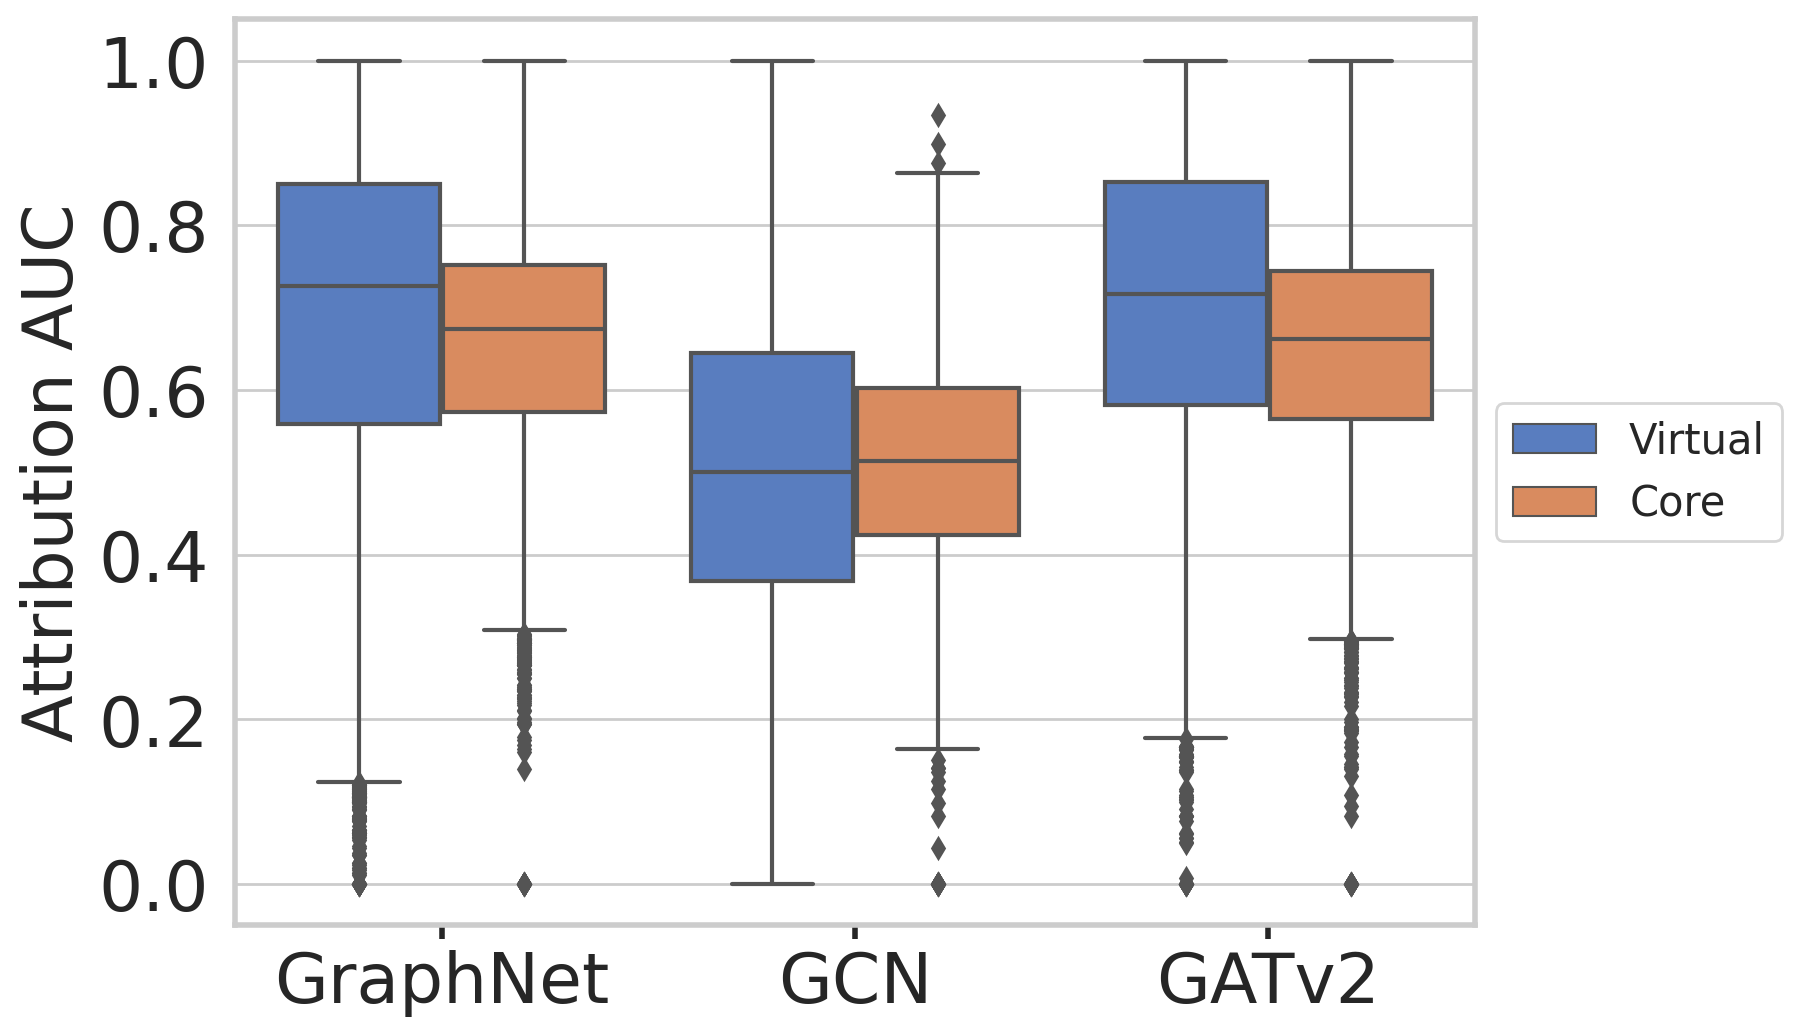

In [105]:
fig, ax = plt.subplots(figsize =(8, 6))
sns.boxplot(data=df_auc_gnns, x='df_gnn', y='val', hue='orbital', ax=ax)

ax.set_xticklabels(['GraphNet', 'GCN', 'GATv2'])
ax.set_ylabel("Attribution AUC")
ax.set_xlabel("")
ax.tick_params(axis='x', which='major', direction='out', 
               bottom=True, width=2, length=5)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.savefig("./auc_all_gnns.png",  dpi=300, bbox_inches='tight')

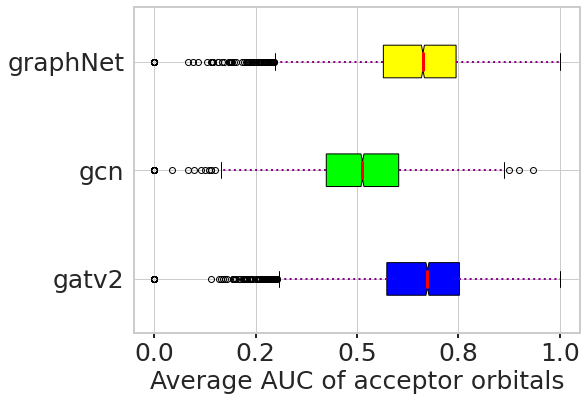

In [11]:
fig, ax = plt.subplots(figsize =(8, 6))

bp = ax.boxplot([df['avg_auc_don'].to_numpy()\
           for df in auc_gnns.values()], 
           patch_artist = True,
           notch ='False', vert = 0)

ax.set_yticklabels([k for k in auc_gnns.keys()])
ax.set_xlabel("Average AUC of acceptor orbitals")
ax.tick_params(axis='x', which='major', direction='out', 
               bottom=True, width=2, length=5)
ax.xaxis.set_major_formatter(FormatStrFormatter("%.1f"))

colors = ['#0000FF', '#00FF00',
          '#FFFF00', '#FF00FF']
 
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)
    
for median in bp['medians']:
    median.set(color ='red',
               linewidth = 3)
    
for whisker in bp['whiskers']:
    whisker.set(color ='#8B008B',
                linewidth = 2,
                linestyle =":")  
    
#plt.savefig('./auc_boxplot_acc.png', dpi=300, bbox_inches='tight')

In [12]:
auc_gcn = pd.read_csv(f"/home/kotobiam/hida_project/data/avg_auc/old/avg_auc_gatv2.csv").fillna(0)

In [13]:
auc_gcn.loc[(auc_gcn['avg_auc_acc'] == 1) &\
        (auc_gcn['avg_auc_don'] == 1)]

,Unnamed: 0,avg_auc_acc,avg_auc_don
2,2,1.0,1.0


# all average auc data with index of molecules 

In [64]:
all_testData_inds = {i : graph.idx for i, graph\
                     in enumerate(test_data) if i != 4817}

In [155]:
rse_dir = '/home/kotobiam/hida_project/data/rse_data'
avgAuc_dir = '/home/kotobiam/hida_project/data/avg_auc/old'

for gnn in gnns:
    df_rse = pd.read_csv(osp.join(rse_dir, f"RSE_{gnn}.csv"))
    df_auc = pd.read_csv(osp.join(avgAuc_dir, f"avg_auc_{gnn}.csv"))
    df_auc.columns = ['mol_idx', 'avg_auc_acc', 'avg_auc_don']
    df_auc[['mol_idx']] = df_auc[['mol_idx']].replace(
        all_testData_inds.keys(),
        all_testData_inds.values())
    rse_auc_dict = {}
    for v in list(df_rse['mol_idx']):
        rse_auc_dict[v] = {'avg_auc_acc' : df_auc[df_auc['mol_idx'] == v]['avg_auc_acc'].values,
                           'avg_auc_don' : df_auc[df_auc['mol_idx'] == v]['avg_auc_don'].values,
                           'rse' : df_rse[df_rse['mol_idx'] == v]['RSE'].values,
                           'smiles' : qm9_smiles.iloc[v].values}
    
    pd.DataFrame.from_dict(rse_auc_dict).T.to_csv(f"./rse_auc_{gnn}.csv")

# Perturbations

In [81]:
import glob
import collections
from scipy.signal import find_peaks
from sklearn.preprocessing import MinMaxScaler


from rdkit.Chem import PandasTools
from rdkit import Chem
from rdkit.Chem.rdchem import BondType as BT
from rdkit.Chem.rdchem import HybridizationType

import torch
from torch_scatter import scatter
from torch_geometric.data import Data, Dataset
from tqdm import tqdm
from utils.broadening import spectrum

## prepare graphs of perturbed molecules 

In [1]:
path_smiles = '/home/kotobiam/hida_project/Perturbation/perturbed_smiles.csv'
pert_smiles = pd.read_csv(path_smiles)

In [76]:
pert1_smiles = pert_smiles.drop('perturbed2', axis=1)
pert2_smiles = pert_smiles.drop('perturbed1', axis=1).dropna()

In [77]:
PandasTools.AddMoleculeColumnToFrame(pert2_smiles, 'perturbed2', 'id')
PandasTools.WriteSDF(pert2_smiles, './pert2_out.sdf', molColName='id')

NameError: name 'PandasTools' is not defined

In [78]:
suppl_pert1 = Chem.SDMolSupplier('/home/kotobiam/hida_project/data/pert1_out.sdf', 
                           removeHs=False, sanitize=False)
suppl_pert2 = Chem.SDMolSupplier('/home/kotobiam/hida_project/data/pert2_out.sdf', 
                           removeHs=False, sanitize=False)

In [82]:
def perturbed_graph(suppl_pert, pert_smiles):
    
    types = {'H': 0, 'C': 1, 'N': 2, 'O': 3, 'F': 4}
    bonds = {BT.SINGLE: 0, BT.DOUBLE: 1, BT.TRIPLE: 2, BT.AROMATIC: 3}
    
    data_list = []

    for mol, i in zip(suppl_pert, list(pert_smiles['id'])):
        N = mol.GetNumAtoms()
        conf = mol.GetConformer()
        pos = conf.GetPositions()
        pos = torch.tensor(pos, dtype=torch.float)
    
        type_idx = []
        atomic_number = []
        aromatic = []
        sp = []
        sp2 = []
        sp3 = []
        num_hs = []

        for atom in mol.GetAtoms():
            type_idx.append(types[atom.GetSymbol()])
            atomic_number.append(atom.GetAtomicNum())
            aromatic.append(1 if atom.GetIsAromatic() else 0)
            hybridization = atom.GetHybridization()
            sp.append(1 if hybridization == HybridizationType.SP else 0)
            sp2.append(1 if hybridization == HybridizationType.SP2 else 0)
            sp3.append(1 if hybridization == HybridizationType.SP3 else 0)

        z = torch.tensor(atomic_number, dtype=torch.long)

        row, col, edge_type = [], [], []
        for bond in mol.GetBonds():
            start, end = bond.GetBeginAtomIdx(), bond.GetEndAtomIdx()
            row += [start, end]
            col += [end, start]
            edge_type += 2 * [bonds[bond.GetBondType()]]

        edge_index = torch.tensor([row, col], dtype=torch.long)
        edge_type = torch.tensor(edge_type, dtype=torch.long)
        edge_attr = torch.nn.functional.one_hot(
                  edge_type, num_classes=len(bonds)
                   ).to(torch.float)

        perm = (edge_index[0] * N + edge_index[1]).argsort()
        edge_index = edge_index[:, perm]
        edge_type = edge_type[perm]
        edge_attr = edge_attr[perm]

        row, col = edge_index
        hs = (z == 1).to(torch.float)
        num_hs = scatter(hs[row], col, dim_size=N).tolist()

        x1 = torch.nn.functional.one_hot(
                  torch.tensor(type_idx), num_classes=len(types)
                )
        x2 = torch.tensor([atomic_number, aromatic, sp, sp2, sp3, num_hs],
                                dtype=torch.float).t().contiguous()

        x = torch.cat([x1.to(torch.float), x2], dim=-1)

        data = Data(x=x, z=z, pos=pos, edge_index=edge_index,
                          edge_attr=edge_attr, idx=i)
        data_list.append(data)
        
    return data_list

In [83]:
all_graphs_pert = {'perturbed1': perturbed_graph(suppl_pert1, pert1_smiles), 
                   'perturbed2': perturbed_graph(suppl_pert2, pert2_smiles)}

In [84]:
all_graphs_pert

{'perturbed1': [Data(x=[10, 11], edge_index=[2, 22], edge_attr=[22, 4], pos=[10, 3], z=[10], idx=35015),
  Data(x=[10, 11], edge_index=[2, 20], edge_attr=[20, 4], pos=[10, 3], z=[10], idx=26403),
  Data(x=[10, 11], edge_index=[2, 20], edge_attr=[20, 4], pos=[10, 3], z=[10], idx=31991),
  Data(x=[9, 11], edge_index=[2, 18], edge_attr=[18, 4], pos=[9, 3], z=[9], idx=20592),
  Data(x=[10, 11], edge_index=[2, 20], edge_attr=[20, 4], pos=[10, 3], z=[10], idx=55471),
  Data(x=[8, 11], edge_index=[2, 14], edge_attr=[14, 4], pos=[8, 3], z=[8], idx=1184),
  Data(x=[10, 11], edge_index=[2, 22], edge_attr=[22, 4], pos=[10, 3], z=[10], idx=34628),
  Data(x=[10, 11], edge_index=[2, 20], edge_attr=[20, 4], pos=[10, 3], z=[10], idx=53205),
  Data(x=[10, 11], edge_index=[2, 22], edge_attr=[22, 4], pos=[10, 3], z=[10], idx=52944),
  Data(x=[10, 11], edge_index=[2, 20], edge_attr=[20, 4], pos=[10, 3], z=[10], idx=32120),
  Data(x=[9, 11], edge_index=[2, 18], edge_attr=[18, 4], pos=[9, 3], z=[9], idx=123

## index of orca files 

In [85]:
path_to_pert = "/beegfs/desy/user/kotobiam/DFT_calculations/nexafs_dataset_prep/QM9_dataset_nexafs/qm9_perturbation_XAI/"

In [86]:
all_pert_fnames = collections.defaultdict(dict)
for file in glob.glob(osp.join(path_to_pert,
                               "*perturb*/structure_*/")):
    fname1 = file.split("/")[-3].split("_")[0]
    fname2 = file.split("/")[-2].split("_")[1]
    pert_type = file.split("/")[-3].split("_")[1]
    all_pert_fnames[fname1].update({pert_type: fname2})

In [87]:
all_pert_fnames

defaultdict(dict,
            {'32852': {'perturbed1': '23', 'perturbed2': '24'},
             '27256': {'perturbed2': '16', 'perturbed1': '15'},
             '31991': {'perturbed1': '17', 'perturbed2': '18'},
             '53205': {'perturbed1': '31', 'perturbed2': '32'},
             '14023': {'perturbed2': '10', 'perturbed1': '9'},
             '12362': {'perturbed2': '7', 'perturbed1': '6'},
             '11269': {'perturbed2': '5', 'perturbed1': '4'},
             '32642': {'perturbed2': '22', 'perturbed1': '21'},
             '20592': {'perturbed2': '12', 'perturbed1': '11'},
             '1674': {'perturbed2': '2', 'perturbed1': '1'},
             '1184': {'perturbed1': '0'},
             '52944': {'perturbed1': '29', 'perturbed2': '30'},
             '34628': {'perturbed1': '25', 'perturbed2': '26'},
             '26403': {'perturbed1': '13', 'perturbed2': '14'},
             '32120': {'perturbed1': '19', 'perturbed2': '20'},
             '2936': {'perturbed1': '3'},
          

## add spectrum label to the graphs

In [88]:
path_to_spec = "/beegfs/desy/user/kotobiam/DFT_calculations/nexafs_dataset_prep/QM9_dataset_nexafs/qm9_perturbation_XAI/"

In [89]:
energies = torch.linspace(270, 300, 100)
sigma=torch.tensor(0.8)

for pert_type, graphs in all_graphs_pert.items():
    for g in graphs:
        mol_idx = g.idx 
        fileExt = all_pert_fnames[str(mol_idx)][pert_type]
        spec = np.loadtxt(
            osp.join(path_to_spec,
                     f"{mol_idx}_{pert_type}/structure_{fileExt}/structure_{fileExt}.out.abs.stk")
        )
        E = torch.tensor(spec[:, 0])
        osc = torch.tensor(spec[:, 1])
        g.spectrum = spectrum(E, osc, sigma, energies)

In [90]:
all_graphs_pert

{'perturbed1': [Data(x=[10, 11], edge_index=[2, 22], edge_attr=[22, 4], pos=[10, 3], z=[10], idx=35015, spectrum=[100]),
  Data(x=[10, 11], edge_index=[2, 20], edge_attr=[20, 4], pos=[10, 3], z=[10], idx=26403, spectrum=[100]),
  Data(x=[10, 11], edge_index=[2, 20], edge_attr=[20, 4], pos=[10, 3], z=[10], idx=31991, spectrum=[100]),
  Data(x=[9, 11], edge_index=[2, 18], edge_attr=[18, 4], pos=[9, 3], z=[9], idx=20592, spectrum=[100]),
  Data(x=[10, 11], edge_index=[2, 20], edge_attr=[20, 4], pos=[10, 3], z=[10], idx=55471, spectrum=[100]),
  Data(x=[8, 11], edge_index=[2, 14], edge_attr=[14, 4], pos=[8, 3], z=[8], idx=1184, spectrum=[100]),
  Data(x=[10, 11], edge_index=[2, 22], edge_attr=[22, 4], pos=[10, 3], z=[10], idx=34628, spectrum=[100]),
  Data(x=[10, 11], edge_index=[2, 20], edge_attr=[20, 4], pos=[10, 3], z=[10], idx=53205, spectrum=[100]),
  Data(x=[10, 11], edge_index=[2, 22], edge_attr=[22, 4], pos=[10, 3], z=[10], idx=52944, spectrum=[100]),
  Data(x=[10, 11], edge_index=

# visualise XAS spectra 

In [49]:
def xas_pert(pert_graph, model, gnn_type):
     # graph data
    graph = copy.deepcopy(pert_graph)
    graph_cam = copy.deepcopy(pert_graph)
            
    model.to('cpu')
    model.eval()
    with torch.no_grad():
        if gnn_type == 'graphNet':
            # input only graph
            y_pred = model(graph)
        else:
            y_pred = model(graph.x,
                           graph.edge_index,
                           graph.batch)
                
    x_pred = np.linspace(270, 300, 100)
    y_pred = y_pred.numpy().flatten()
    y_true = graph.spectrum 
    
    plot_prediction(x_pred, 
                y_pred, 
                y_true, 
                normalise=True, 
                add_peaks=False,
                save=True)

In [50]:
all_graphs_pert['perturbed2'][4]

Data(x=[10, 11], edge_index=[2, 20], edge_attr=[20, 4], pos=[10, 3], z=[10], idx=55471, spectrum=[100])

In [51]:
xas_pert(all_graphs_pert['perturbed1'][4],
         spectragnn, gnn_type='gcn')

NameError: name 'plot_prediction' is not defined

# AUC

In [71]:
def perturbation_auc(path_to_pert, mol_idx, 
                     structure_idx, model, 
                     pert_graph, gnn_type):

    # graph data
    graph = copy.deepcopy(pert_graph)
    graph_cam = copy.deepcopy(pert_graph)
            
    model.to('cpu')
    model.eval()
    with torch.no_grad():
        if gnn_type == 'graphNet':
            # input only graph
            y_pred = model(graph)
        else:
            y_pred = model(graph.x,
                           graph.edge_index,
                           graph.batch)
                
    x_pred = np.linspace(270, 300, 100)
    y_pred = y_pred.numpy().flatten()
    y_true = graph.spectrum 
    atomic_num = graph.z
    label_map = {1: 'H', 6: 'C', 7: 'N', 8: 'O', 9: 'F'}
    atom_labels = []
    for i, z in enumerate(atomic_num):
        atom_labels.append(f"{label_map[z.item()]} {i}")
        
    # attribution data
    if gnn_type == 'graphNet':
        cam_data = cam_graphnet(graph_cam, model)
    else:
        cam_data = cam_gnn(graph, model)
    
    
    all_cam_data = pd.DataFrame(np.c_[x_pred, y_pred, cam_data.T], 
             columns=['energies', 'osc', *atom_labels])
    # ground truth data
    path_orca_output = osp.join(path_to_pert, 
                                f"structure_{structure_idx}/structure_{structure_idx}.out")
    path_orca_spectrum = osp.join(path_to_pert,
                                  f"structure_{structure_idx}/structure_{structure_idx}.out.abs.stk")

    orca_analyzer = OrcaAnlyser(path_orca_output,
                                path_orca_spectrum)
    excitations = orca_analyzer.give_excitations()
    
    # finding the peaks in spectrum
    peaks, _ = find_peaks(y_pred)
    all_peaks = x_pred[peaks]
    all_peaks = [peak for peak in all_peaks \
                     if peak > 274 and peak < 296]
    
    aucs_don = []
    aucs_acc = []
    for peak in all_peaks:
        contributions = Contributions(excitations, 
                              all_cam_data, 
                              peak, atom_labels)
        acc, don = contributions.don_acc_contrs()
        cam_contr = contributions.cam_contrs()
        if don.empty and acc.empty:
            continue
        else:
            aucs_don.append(auc(
                np.asarray(cam_contr['weights']), 
                np.asarray(don['weights']))[0])
            aucs_acc.append(auc(
                np.asarray(cam_contr['weights']), 
                np.asarray(acc['weights']))[0])
        
    return aucs_don, aucs_acc

In [72]:
all_pert_fnames

defaultdict(dict,
            {'32852': {'perturbed1': '23', 'perturbed2': '24'},
             '27256': {'perturbed2': '16', 'perturbed1': '15'},
             '31991': {'perturbed1': '17', 'perturbed2': '18'},
             '53205': {'perturbed1': '31', 'perturbed2': '32'},
             '14023': {'perturbed2': '10', 'perturbed1': '9'},
             '12362': {'perturbed2': '7', 'perturbed1': '6'},
             '11269': {'perturbed2': '5', 'perturbed1': '4'},
             '32642': {'perturbed2': '22', 'perturbed1': '21'},
             '20592': {'perturbed2': '12', 'perturbed1': '11'},
             '1674': {'perturbed2': '2', 'perturbed1': '1'},
             '1184': {'perturbed1': '0'},
             '52944': {'perturbed1': '29', 'perturbed2': '30'},
             '34628': {'perturbed1': '25', 'perturbed2': '26'},
             '26403': {'perturbed1': '13', 'perturbed2': '14'},
             '32120': {'perturbed1': '19', 'perturbed2': '20'},
             '2936': {'perturbed1': '3'},
          

In [78]:
all_pert_auc = collections.defaultdict(dict)

for mol_idx, value in all_pert_fnames.items():
    all_pert_auc[mol_idx].update({"unperturbed": gt_generator[
        return_idx(test_data, int(mol_idx))
    ]})
    
    for pert_type, structure_idx in value.items():
        graph = [graph for graph in \
        all_graphs_pert[pert_type] if graph.idx == int(mol_idx)] 
        
        try:
            all_pert_auc[mol_idx].update({
                pert_type: perturbation_auc(osp.join(path_to_pert, f"{mol_idx}_{pert_type}"), 
                     int(mol_idx), structure_idx, spectragraphnet, graph[0], gnn_type="graphNet")})
        except Exception as e:
            print(e)
            #print(f"structure{key} has error in {(k, v)}")

In [79]:
all_pert_auc

defaultdict(dict,
            {'32852': {'unperturbed': {278.4848484848485: {'auc_donor': (0.08928571428571427,
                 array([0.        , 0.07142857, 0.14285714, 0.28571429, 0.5       ,
                        0.71428571, 0.71428571, 0.92857143, 0.92857143, 1.        ,
                        1.        ]),
                 array([0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.25, 0.25, 0.5 , 0.5 , 1.  ])),
                'auc_acceptor': (0.25,
                 array([0.    , 0.0625, 0.125 , 0.25  , 0.4375, 0.6875, 0.6875, 0.8125,
                        0.8125, 1.    ]),
                 array([0. , 0. , 0. , 0. , 0. , 0. , 0.5, 0.5, 1. , 1. ]))},
               285.1515151515151: {'auc_donor': (0.9846153846153847,
                 array([0.        , 0.        , 0.        , 0.07692308, 0.07692308,
                        0.30769231, 0.46153846, 0.69230769, 1.        ]),
                 array([0. , 0.2, 0.8, 0.8, 1. , 1. , 1. , 1. , 1. ])),
                'auc_acceptor': (0.875,
   

In [80]:
don_auc_changes = []
acc_auc_changes = []

for auc_values in all_pert_auc.values():
    for auc_type, auc_vals in auc_values.items():
        if auc_type == 'unperturbed':
            auc_don_unpert = np.mean([gt_mol['auc_donor'][0]\
                                               for gt_mol in auc_vals.values()])

            auc_acc_unpert = np.mean([gt_mol['auc_acceptor'][0]\
                                              for gt_mol in auc_vals.values()])
        else:
            don_auc_changes.append(np.abs(auc_don_unpert - np.mean(auc_vals[0])))
            acc_auc_changes.append(np.abs(auc_acc_unpert - np.mean(auc_vals[1])))

In [48]:
gnns = ['gatv2', 'gcn', 'graphNet']
auc_change_models = {}

In [81]:
auc_change_models['graphNet'] = {'change_auc_don': MinMaxScaler().fit_transform(
    np.asarray(don_auc_changes).reshape(-1, 1)),
                            'change_auc_acc': MinMaxScaler().fit_transform(
    np.asarray(acc_auc_changes).reshape(-1, 1))}

In [82]:
auc_change_models

{'gcn': {'change_auc_don': array([[0.35865896],
         [0.95764627],
         [0.07865947],
         [0.02043338],
         [0.        ],
         [0.09493384],
         [0.35132622],
         [0.01167405],
         [0.23616765],
         [0.64251693],
         [1.        ],
         [0.8268889 ],
         [0.42125966],
         [0.50805631],
         [0.73484347],
         [0.46378476],
         [0.47502536],
         [0.50034105],
         [0.26611064],
         [0.03320629],
         [0.94990319],
         [0.24772708],
         [0.85313372],
         [0.50004431],
         [0.57779964],
         [0.54517274],
         [0.39707596],
         [0.07722107],
         [0.1251006 ],
         [0.53834198],
         [0.79446787],
         [0.67052647],
         [0.07102141],
         [0.46146338],
         [0.30703767]]),
  'change_auc_acc': array([[0.71412577],
         [0.93506033],
         [0.03761769],
         [0.22293197],
         [0.        ],
         [0.16549564],
         [0.

In [91]:
df = pd.DataFrame()
for gnn, auc_change in auc_change_models.items():
    for auc_type, changes in auc_change.items():
        df_gnn = pd.DataFrame()
        df_gnn['val'] = changes.flatten().tolist() 
        df_gnn['auc_type'] = auc_type
        df_gnn['gnn_type'] = gnn
        df = df.append(df_gnn, ignore_index=True)

In [91]:
#df.to_csv("./changes_auc_all_gnns.csv")

In [92]:
df = df.replace('change_auc_don', 'AUC core orbitals')
df = df.replace('change_auc_acc', 'AUC virtual orbitals')

In [93]:
df['val'] = df['val'] * 100

In [125]:
df

,val,auc_type,gnn_type
0,35.865896,AUC core orbitals,gcn
1,95.764627,AUC core orbitals,gcn
2,7.865947,AUC core orbitals,gcn
3,2.043338,AUC core orbitals,gcn
4,0.000000,AUC core orbitals,gcn
...,...,...,...
205,29.359834,AUC acceptor orbitals,graphNet
206,33.416049,AUC acceptor orbitals,graphNet
207,64.080407,AUC acceptor orbitals,graphNet
208,100.000000,AUC acceptor orbitals,graphNet


In [95]:
df.to_csv("/home/kotobiam/hida_project/data/auc_changes_allModels.csv", index_label=None)

In [86]:
df = pd.read_csv("/home/kotobiam/hida_project/data/auc_changes_allModels.csv")

In [87]:
df

,Unnamed: 0,val,auc_type,gnn_type
0,0,35.865896,AUC core orbitals,gcn
1,1,95.764627,AUC core orbitals,gcn
2,2,7.865947,AUC core orbitals,gcn
3,3,2.043338,AUC core orbitals,gcn
4,4,0.000000,AUC core orbitals,gcn
...,...,...,...,...
205,205,29.359834,AUC acceptor orbitals,graphNet
206,206,33.416049,AUC acceptor orbitals,graphNet
207,207,64.080407,AUC acceptor orbitals,graphNet
208,208,100.000000,AUC acceptor orbitals,graphNet


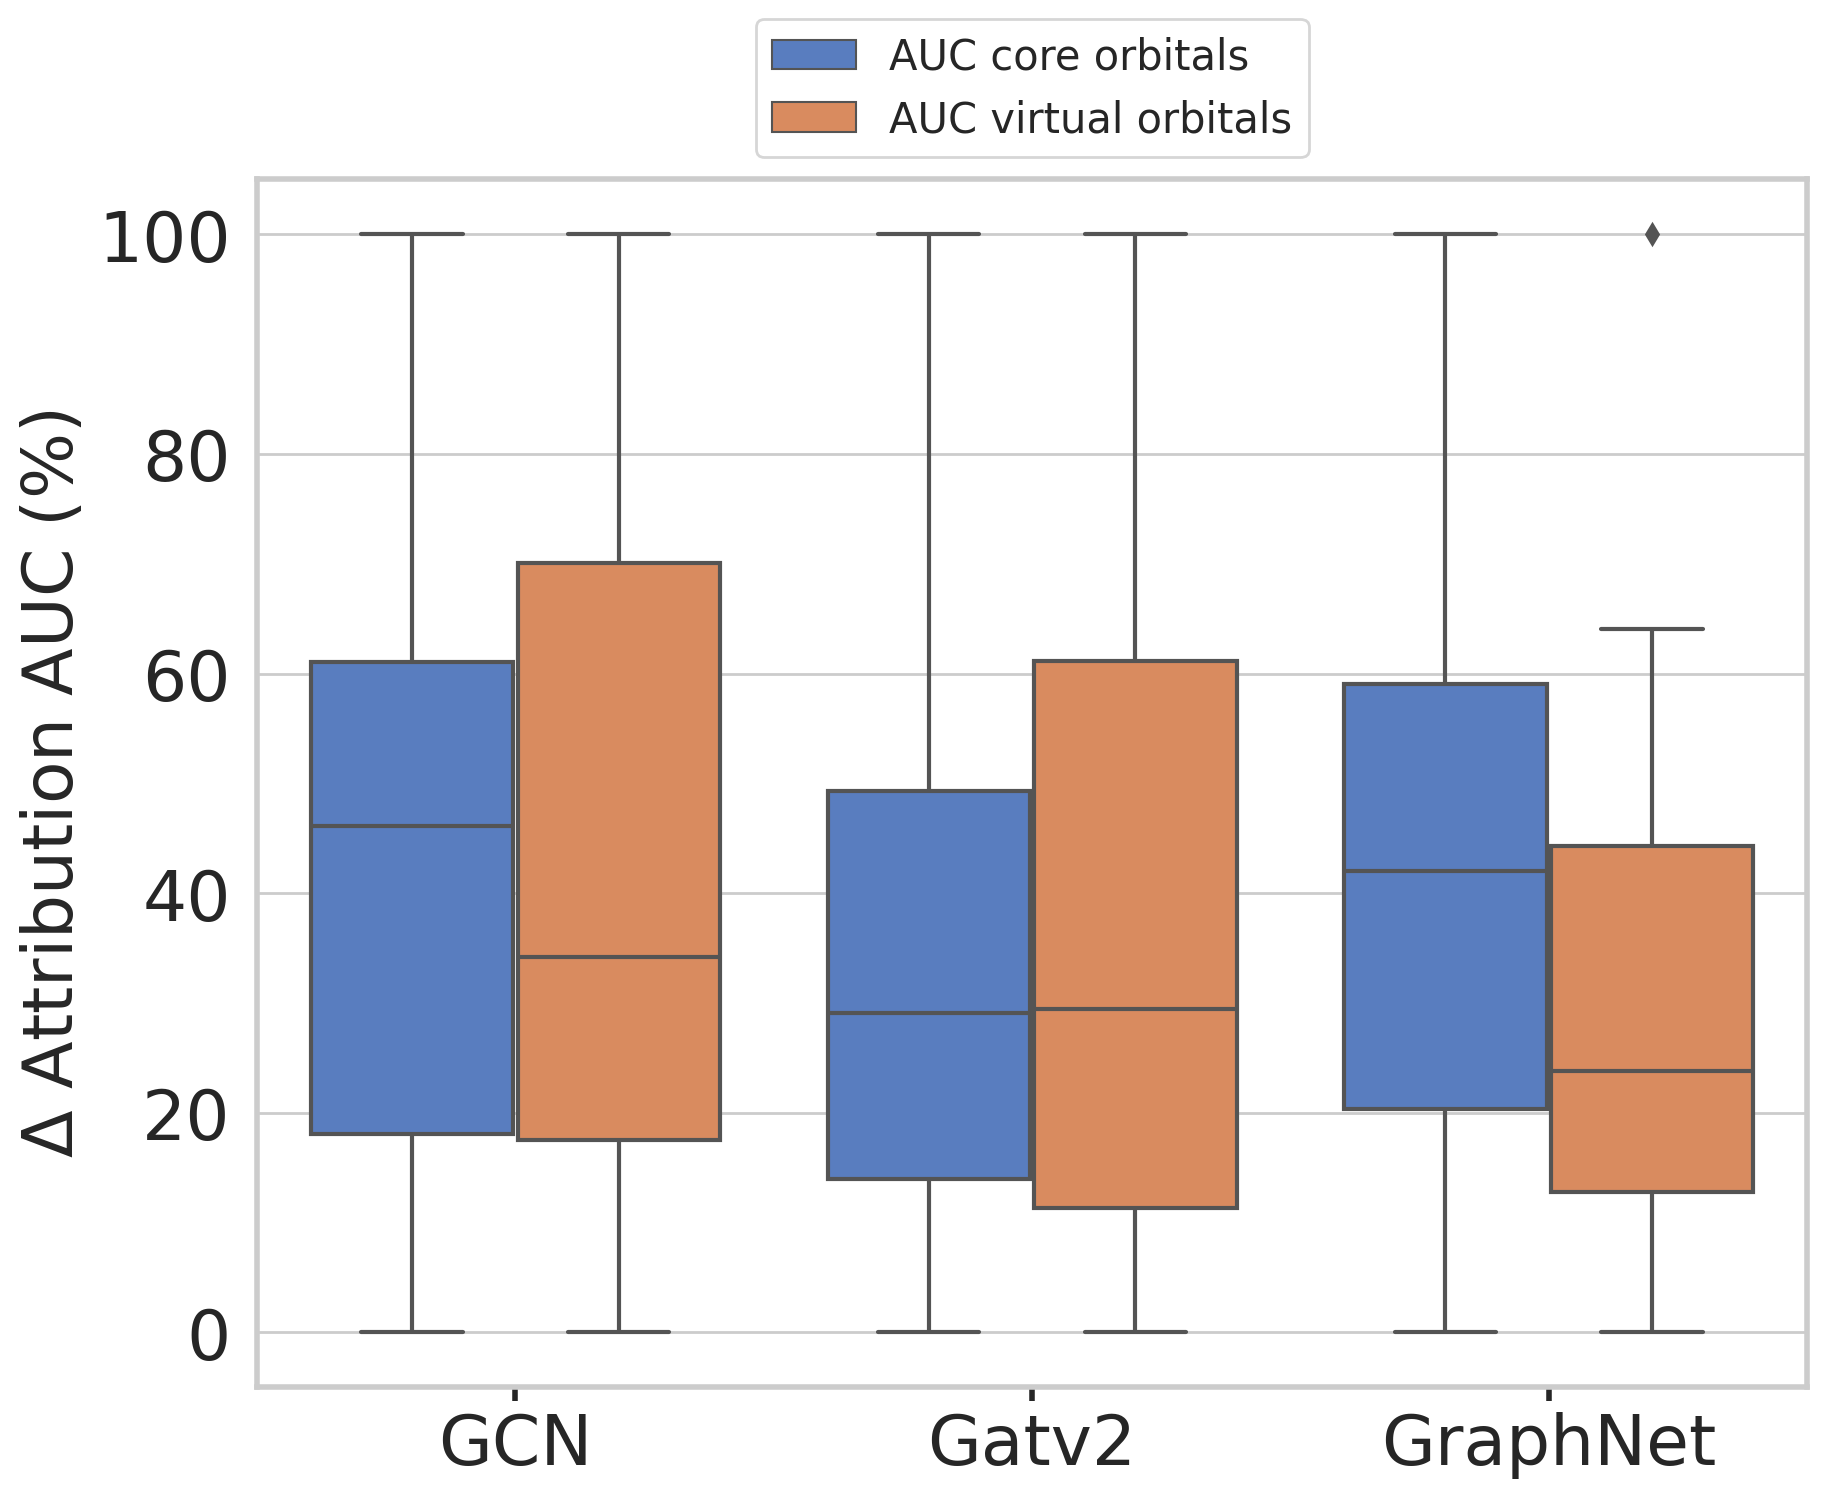

In [98]:
fig, ax = plt.subplots(figsize =(10, 8))
sns.boxplot(data=df, x='gnn_type', y='val', hue='auc_type', ax=ax)

ax.set_xticklabels(['GCN', 'Gatv2', 'GraphNet'])
ax.set_ylabel("$\Delta$ Attribution AUC (%)")
ax.set_xlabel("")
ax.tick_params(axis='x', which='major', direction='out', 
               bottom=True, width=2, length=5)
ax.legend()
sns.move_legend(ax, "upper center", bbox_to_anchor=(0.5,1.15)) 
plt.savefig("./changes_auc_all_gnns.png",  dpi=300, bbox_inches='tight')

# change in the RSE distribution after perturbation 

In [71]:
from utils.rse import rse_predictions, rse_histogram, rse_loss

## RSE distribtion after perturbation 

In [98]:
rse_dist_pert = []
for i in range(2):
    rse_dict = rse_predictions(spectragraphnet, 
                               all_graphs_pert[f"perturbed{i+1}"]
                               ,graphnet=True)
    rse_dict = {k: v.numpy() for k, v in rse_dict.items() if v < 1}
    rse_dist_pert.extend(rse_dict.values())

In [93]:
rse_dist_pert

[array(0.19827967),
 array(0.18062338),
 array(0.09968137),
 array(0.16692388),
 array(0.1403287),
 array(0.16130873),
 array(0.16252614),
 array(0.21863303),
 array(0.30847344),
 array(0.15211572),
 array(0.18608817),
 array(0.19576965),
 array(0.18053282),
 array(0.19859916),
 array(0.17125943),
 array(0.17128343),
 array(0.21324516),
 array(0.19086586),
 array(0.14933608),
 array(0.19756539),
 array(0.1736898),
 array(0.13701703),
 array(0.10951923),
 array(0.14859285),
 array(0.14814912),
 array(0.19898858),
 array(0.26568925),
 array(0.14695024),
 array(0.18530922),
 array(0.1678059),
 array(0.1999007),
 array(0.16944488),
 array(0.14065389),
 array(0.21599372),
 array(0.19248804)]

In [100]:
df_rse_pert = pd.DataFrame({'RSE': rse_dist_pert})
df_rse_pert['Type'] = 'perturbed molecules'

In [101]:
df_rse_pert

,RSE,Type
0,0.11530648782024398,perturbed molecules
1,0.13029561641034715,perturbed molecules
2,0.12000564766874522,perturbed molecules
3,0.15072222363618645,perturbed molecules
4,0.12394837150322197,perturbed molecules
5,0.1335915222995471,perturbed molecules
6,0.11587323905072251,perturbed molecules
7,0.16009771907608367,perturbed molecules
8,0.1934201139204899,perturbed molecules
9,0.122468200314219,perturbed molecules


## RSE distribtion before perturbation 

In [102]:
idxs = list(all_pert_fnames.keys())
target_pert_mols = [graph for graph in test_data \
                    if graph.idx in list(map(int, idxs))]

In [103]:
target_pert_mols

[Data(x=[17, 11], edge_index=[2, 32], edge_attr=[32, 4], pos=[17, 3], z=[17], spectrum=[100], idx=1184),
 Data(x=[16, 11], edge_index=[2, 30], edge_attr=[30, 4], pos=[16, 3], z=[16], spectrum=[100], idx=1674),
 Data(x=[17, 11], edge_index=[2, 34], edge_attr=[34, 4], pos=[17, 3], z=[17], spectrum=[100], idx=2936),
 Data(x=[15, 11], edge_index=[2, 30], edge_attr=[30, 4], pos=[15, 3], z=[15], spectrum=[100], idx=11269),
 Data(x=[20, 11], edge_index=[2, 40], edge_attr=[40, 4], pos=[20, 3], z=[20], spectrum=[100], idx=12362),
 Data(x=[18, 11], edge_index=[2, 36], edge_attr=[36, 4], pos=[18, 3], z=[18], spectrum=[100], idx=13682),
 Data(x=[20, 11], edge_index=[2, 42], edge_attr=[42, 4], pos=[20, 3], z=[20], spectrum=[100], idx=14023),
 Data(x=[15, 11], edge_index=[2, 30], edge_attr=[30, 4], pos=[15, 3], z=[15], spectrum=[100], idx=20592),
 Data(x=[21, 11], edge_index=[2, 42], edge_attr=[42, 4], pos=[21, 3], z=[21], spectrum=[100], idx=26403),
 Data(x=[18, 11], edge_index=[2, 38], edge_attr=[

In [104]:
rse_dict = rse_predictions(spectragraphnet, target_pert_mols, graphnet=True)
rse_dist_unpert = {k: v.numpy() for k, v in rse_dict.items() if v < 1}

In [105]:
df_rse_unpert = pd.DataFrame({'RSE': list(rse_dist_unpert.values())})
df_rse_unpert['Type'] = 'unperturbed molecules'

In [106]:
df_rse_unpert

,RSE,Type
0,0.02913157,unperturbed molecules
1,0.031663626,unperturbed molecules
2,0.030422578,unperturbed molecules
3,0.057106867,unperturbed molecules
4,0.04141654,unperturbed molecules
5,0.04752882,unperturbed molecules
6,0.032506723,unperturbed molecules
7,0.061844796,unperturbed molecules
8,0.04015824,unperturbed molecules
9,0.054132793,unperturbed molecules


In [107]:
df = df_rse_unpert.append(df_rse_pert)

df['RSE'] = pd.to_numeric(np.array(df['RSE'].tolist()))

df["Type"] = df["Type"].astype("category")

df = df.reset_index(drop=True)

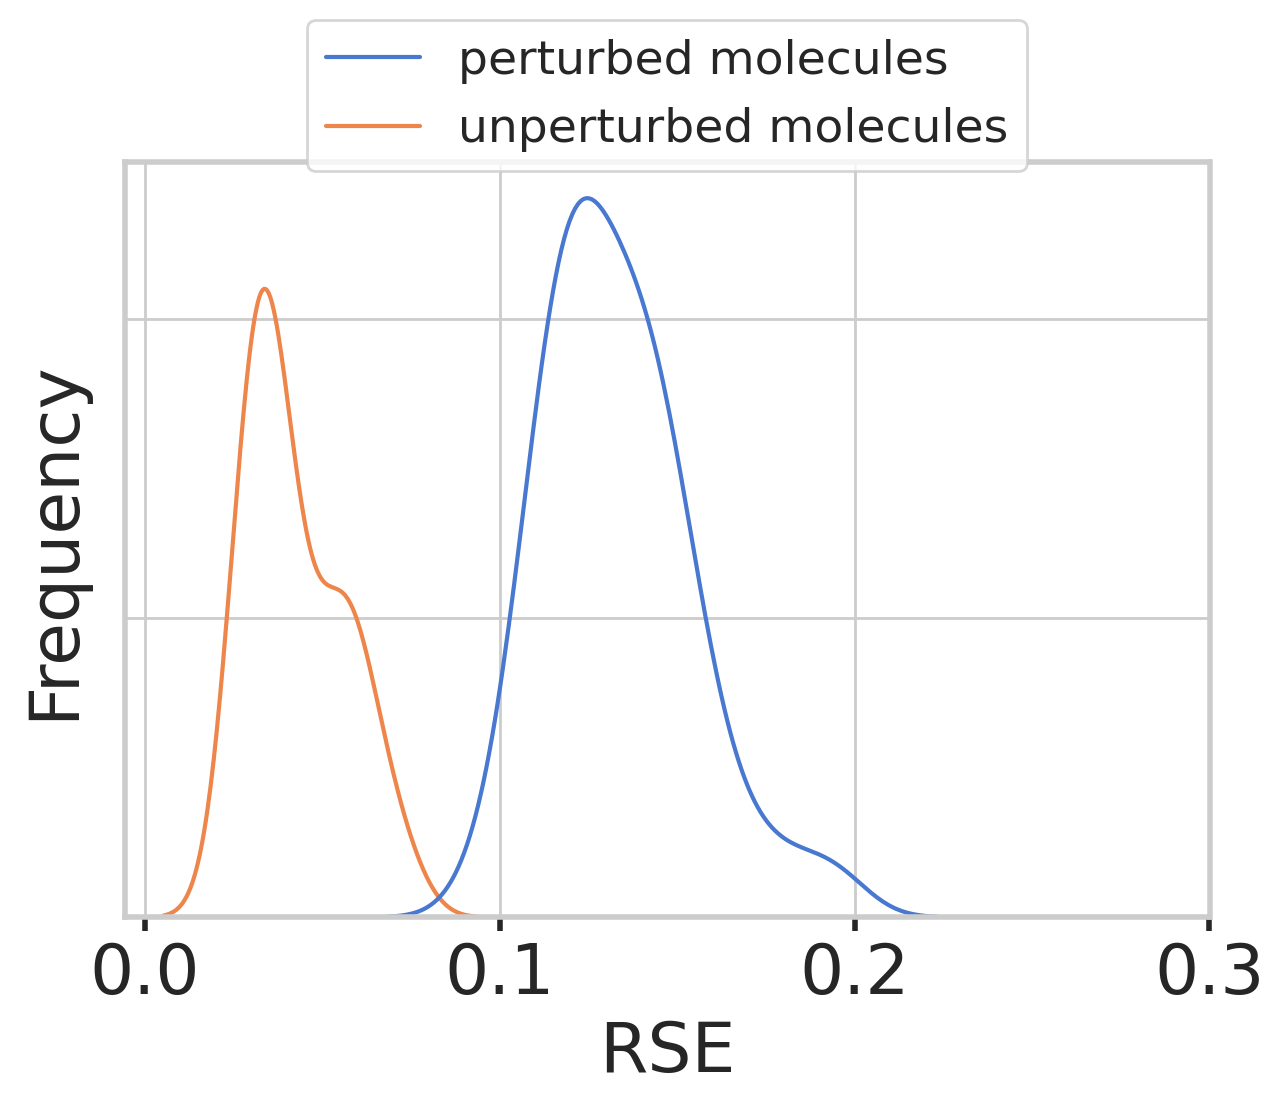

In [118]:
fig, ax = plt.subplots(figsize =(7, 5))
sns.kdeplot(data=df, x="RSE", hue="Type", ax=ax)
ax.set_ylabel("Frequency")
ax.set_yticklabels([])
ax.tick_params(axis='x', which='major', direction='out', 
               bottom=True, width=2, length=5)
sns.move_legend(ax, "upper center", 
                bbox_to_anchor=(0.5,1.22), 
                title='') 
plt.xticks(np.arange(0, 0.35, 0.1))
plt.savefig("./rse_changeDist_GraphNet.png",  
            dpi=400, bbox_inches='tight')

## plotting the perturbed smiles

In [40]:
from rdkit import Chem
from rdkit.Chem import Draw

size = (120, 120)

In [136]:
perturbed_smiles = pd.read_csv('/home/kotobiam/hida_project/Perturbation/pert_combined.csv')

In [139]:
perturbed_smiles.iloc[4]['perturbed1']

'CC1CCOC(C(N)=O)O1'

In [7]:
perturbed_smiles.loc[4]

Unnamed: 0                          4
id                              55471
perturbed1          CC1CCOC(C(N)=O)O1
perturbed2          CC1COC(C(N)=O)OC1
gnet_rse                     0.030773
gnet_avg_auc_acc             0.844444
gnet_avg_auc_don             0.533333
gcn_rse                      0.070653
gcn_avg_auc_acc              0.676852
gcn_avg_auc_don              0.453893
gat_rse                      0.134919
gat_avg_auc_acc              0.961111
gat_avg_auc_don              0.632986
Name: 4, dtype: object

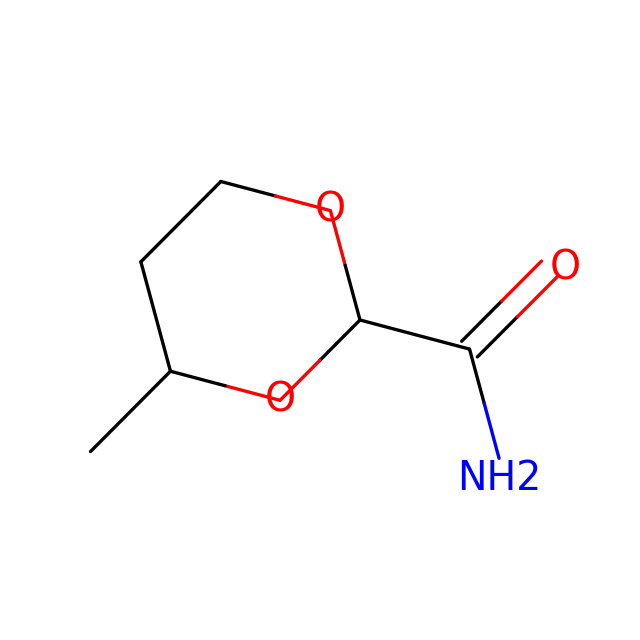

In [15]:
m = Chem.MolFromSmiles(perturbed_smiles.loc[4, 'perturbed1'])
fig = Draw.MolToMPL(m, size=size)
plt.grid(False)
plt.axis('off')
plt.savefig("./smiles_55471_pert1.png",  dpi=300, bbox_inches='tight')

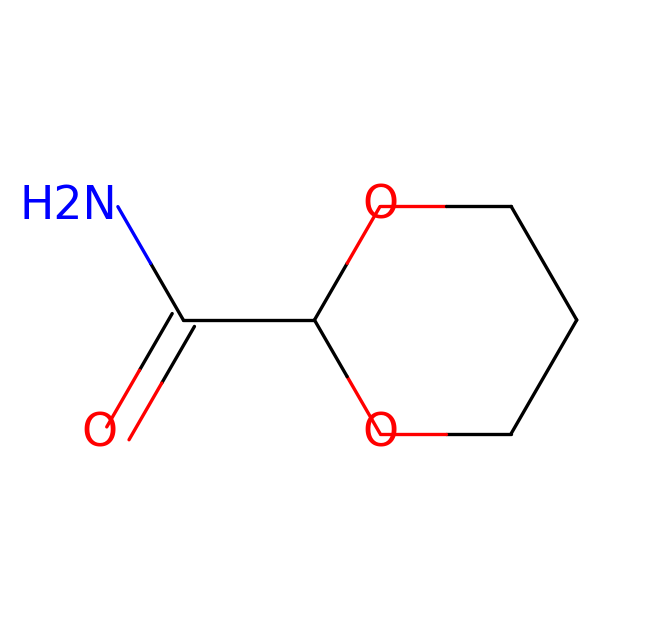

In [19]:
m = Chem.MolFromSmiles(qm9_smiles.loc[55471].values[0])
fig = Draw.MolToMPL(m, size=size)
plt.grid(False)
plt.axis('off')
plt.savefig("./smiles_55471.png",  dpi=300, bbox_inches='tight')

# smiles visualization

In [1]:
import xsmiles
import json

In [4]:
print("XSMILES-JupyterLab version:", xsmiles.__version__) 

XSMILES-JupyterLab version: 0.2.2


In [2]:
molecule = {
          # the smiles string - (RDKit canonical)
          'string': 'CCCCCCCC(=O)Oc1c(Br)cc(C#N)cc1Br',                   
          
          # Optional sequence, in case the app cannot parse your string correctly you can try and split it and input together with the original string
          #'sequence': ["C","C", "C", "C", "C", "C", "C", "C", "(", "=", "O", ")", "O", "c", "1", "c", "(", "Br", ")", "c", "c", "(", "C", "#", "N", ")", "c", "c","1", "Br" ],
    
          # The name of your scores's method and the scored themselves. They should have the size of sequence. 
          # If sequence is not provided, it will automatically create 'sequence' and compare with the size of scores.
          # If they are not matching, try to provide the sequence vector manually, and a scores vector with the same size.
          'methods': [{
            'name': 'My XAI Method',
            'scores': [
              -0.1762678623199463, -0.25460100173950195, -0.2712419033050537,
              -0.2308177947998047, -0.12025833129882812, -0.13311767578125,
              -0.16690635681152344, -0.27755022048950195, -0.38324832916259766,
              -0.2450413703918457, -0.3898346424102783, -0.22409844398498535,
              -0.2113962173461914, -0.12725472450256348, -0.04010510444641113,
              -0.01143336296081543, -0.05576324462890625, 0.18838262557983398,
              0.0361400842666626, 0.0019290447235107422, 0.0008728504180908203,
              -0.028931856155395508, 0.05310940742492676, 0.35703766345977783,
              -0.16322708129882812, 0.07348740100860596, -0.037914276123046875,
              0.0180361270904541, -0.047339677810668945, 0.06556379795074463,
            ],
          }],
          # Custom attributes to be displayed under the graphic
          # Currently it is mandatory, but you can use 'attributes': {}, if you don't have any attributes.
          'attributes': {
            'predicted': 5.300230503082275,          
            'measured': 3.284126043319702,
            'Compound ID': 'bromoxynil octanoate',
          },
        }

In [3]:
# Set up the input: always a vector of 1 or more molecules
molecules = [molecule]

# Currently XSMILES widget only accepts the python dict in json-text format. 
# Use json.dumps():
xsmiles.XSmilesWidget(molecules=json.dumps(molecules))

XSmilesWidget(molecules='[{"string": "CCCCCCCC(=O)Oc1c(Br)cc(C#N)cc1Br", "methods": [{"name": "My XAI Method",…